# Finding Schemata by Matching Polygrams

We attempt to find skipgrams by matching polygrams to schema templates.

## Setup

You need a corpus of files in which to find the schemata.
This notebook assumes that you have a corpus of a form similar to the [mozart-piano-sonatas repository](https://github.com/craigsapp/mozart-piano-sonatas), where the `**kern` scores have been compiled to MIDI without repetitions, i.e., where the corpus directory contains a `midi-norep` directory. For the Mozart Piano Sonata corpus, this can be achieved by `make midi-norep`.

Adjust the following variable to the location of the corpus directory on your drive:

In [1]:
#corpuspath = "/home/chfin/Uni/phd/data/csapp/mozart-piano-sonatas/"
corpuspath = "/home/chfin/Uni/phd/data/csapp/beethoven-string-quartets/"

"/home/chfin/Uni/phd/data/csapp/beethoven-string-quartets/"

We use the DigitalMusicology Library to load Midi Files in the correct representation.
You'll need to install `DigitalMusicology` and `MusicologyPlots` (from git) either to the global julia project or to the local project of this notebook's repo.

In [2]:
import Pkg; Pkg.activate("..")
using Revise # install if necessary

In [3]:
using DigitalMusicology
DigitalMusicology.usekern(corpuspath)

DigitalMusicology.Corpora.Kern.KernCorpus("/home/chfin/Uni/phd/data/csapp/beethoven-string-quartets/", ["quartet01-1", "quartet01-2", "quartet01-3", "quartet01-4", "quartet02-1", "quartet02-2", "quartet02-3", "quartet02-4", "quartet03-1", "quartet03-2"  …  "quartet14-7", "quartet15-1", "quartet15-2", "quartet15-3", "quartet15-4", "quartet15-5", "quartet16-1", "quartet16-2", "quartet16-3", "quartet16-4"])

In [4]:
include("../src/polygrams.jl")
# using Polygrams: piecebarlen, schemamatches

Main.Polygrams

In [5]:
#using Plots; plotlyjs()
#using Rsvg
using MusicologyPlots

## Finding Schemata in a Piece

We choose a piece...

In [6]:
pieceid = "quartet02-1"
#pieceid = "quartet01-2"
notes = getpiece(pieceid, :notes_wholes);
timesigs = getpiece(pieceid, :timesigs);

... define the schemata we look for ...

In [7]:
prinner3v = @midi [[0, 7, 4], [11, 7, 2], [9, 6, 0], [7, 7, 11]]
prinner2v = @midi [[0, 4], [11, 2], [9, 0], [7, 11]]
fonte2v = @midi [[0, 6], [1, 4], [10, 4], [11, 3]]
fonte2vMaj = @midi [[0, 6], [1, 5], [10, 4], [11, 3]]
fonte2vFlipped = @midi [[0, 6], [10, 7], [10, 4], [9, 5]]

4-element Array{Array{MidiPitch,1},1}:
 [0, 6] 
 [10, 7]
 [10, 4]
 [9, 5] 

... find all matches of these schemata in the piece ...

In [8]:
barlen = Polygrams.piecebarlen(pieceid);
schemata = Polygrams.schemamatches(notes, [fonte2v], barlen, barlen);
polys = collect(schemata);

In [9]:
length(polys)

360

... and plot them

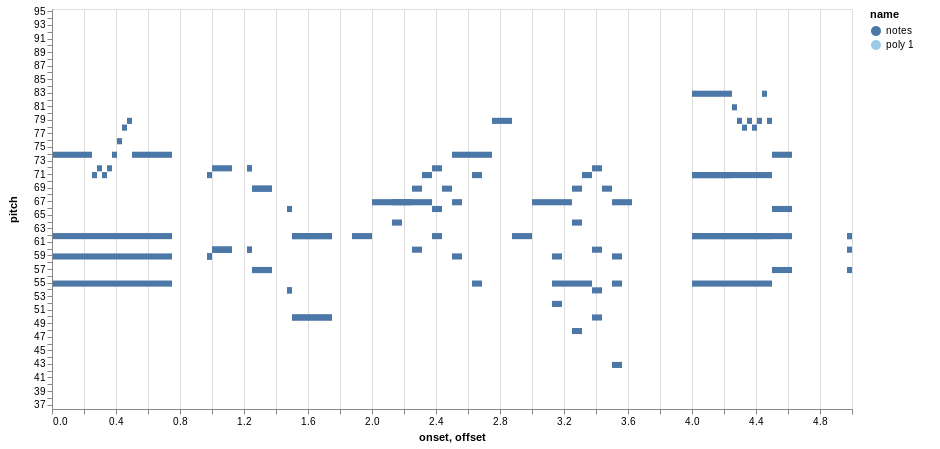

In [10]:
plotpolygrams(notes, [polys[2]], start=0, stop=5)

In [11]:
polys[1]

4-element Array{Array{TimedNote{MidiPitch,Rational{Int64}},1},1}:
 [Note<147//8-37//2>(70), Note<149//8-299//16>(76)]  
 [Note<75//4-301//16>(74), Note<75//4-301//16>(59)]  
 [Note<151//8-303//16>(62), Note<151//8-303//16>(56)]
 [Note<19//1-609//32>(69), Note<307//16-615//32>(73)]

This looks already quite good, but sorting the results by their total duration as well as their voice leading quality pulls the correct instances to the front:

In [12]:
# warning: lots of magic numbers here!
beatfactor = denominator(content(timesigs[1]))
combweight(poly) = (beatfactor * Polygrams.totalduration(poly)
    - 1//12 * Polygrams.voicedist(poly)
    #+ 0.125Polygrams.polymweight(poly, timesigs)
    - beatfactor * 2Polygrams.instageskip(poly))
wpolys = Polygrams.sortbyweight(polys, combweight);
spolys = map(first, wpolys);

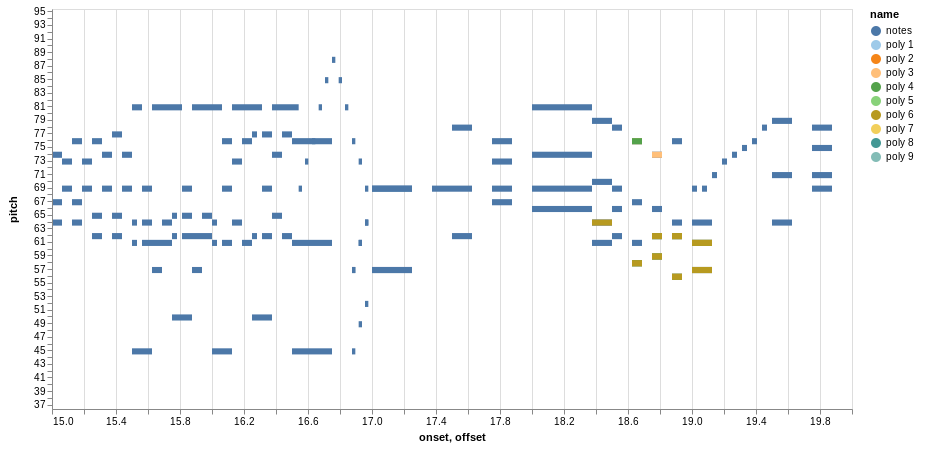

In [13]:
plotpolygrams(notes, spolys[1:9], start=15, stop=20)

Note that the top 4 polygrams correspond to correct schema instances, while the following polygrams correspond to close variants. Use the zooming controls and toggle the polygrams by clicking on the legend to get a better view.

We can improve these results without setting a threshold on the score of a match by selecting only those matches that do not overlap with another match with a higher score:

In [14]:
best = Polygrams.bestmatches(!Polygrams.polyssharetime, spolys);
length(best)

11

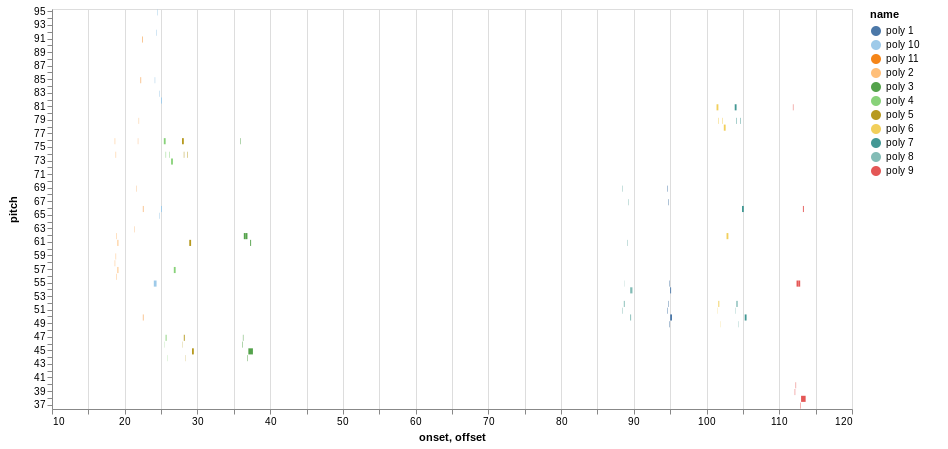

In [15]:
plotpolygrams([], best)

In [16]:
109*4/3

145.33333333333334

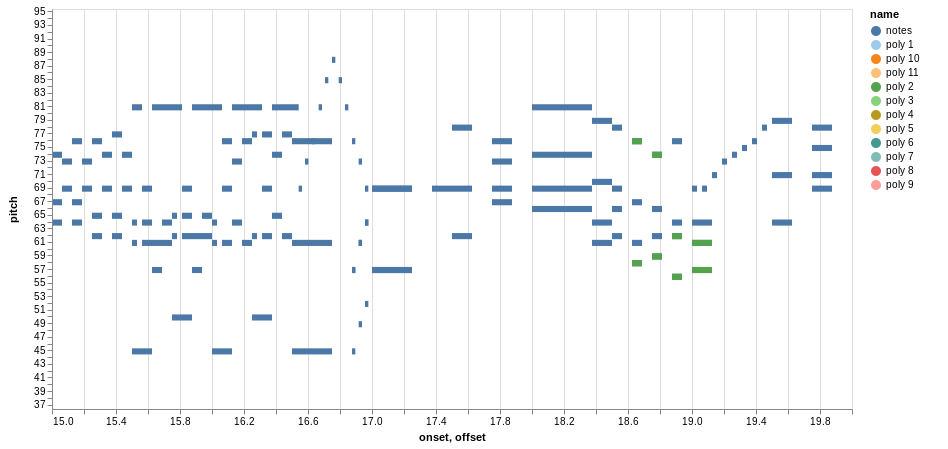

In [17]:
plotpolygrams(notes, best, start=15, stop=20)

In [18]:
plotpolygrams(notes, [polys[5388]], start=4, stop=8)

LoadError: BoundsError: attempt to access 360-element Array{Array{Array{TimedNote{MidiPitch,Rational{Int64}},1},1},1} at index [5388]

In [19]:
combweight(polys[5388])

LoadError: BoundsError: attempt to access 360-element Array{Array{Array{TimedNote{MidiPitch,Rational{Int64}},1},1},1} at index [5388]

In [20]:
combweight(best[2])

5//6

In [21]:
Polygrams.voicedist(polys[4373])

LoadError: BoundsError: attempt to access 360-element Array{Array{Array{TimedNote{MidiPitch,Rational{Int64}},1},1},1} at index [4373]

Voila! In the regions where we have actual instances, the less good competitors vanished. There remain a couple of non-instances in regions, where no schema has been found. Now it might be possible to filter them by their score, as they should be distinguishable from the actual instances:

In [22]:
wbest = Polygrams.sortbyweight(best, combweight)
bar(map(x->x[2], wbest))

LoadError: UndefVarError: bar not defined

Mh, no really. The weighting might need a bit of tuning

In [23]:
wbest[3]

(Array{TimedNote{MidiPitch,Rational{Int64}},1}[[Note<287//8-575//16>(76), Note<289//8-579//16>(46)], [Note<145//4-581//16>(47), Note<291//8-293//8>(62)], [Note<293//8-295//8>(62), Note<295//8-591//16>(44)], [Note<37//1-301//8>(45), Note<149//4-299//8>(61)]], -8//3)

In [24]:
wsearch = filter(wpolys) do poly
    pitches(poly[1][1]) == (@midi [68,74]) &&
    pitches(poly[1][2]) == (@midi [69,72]) &&
    pitches(poly[1][3]) == (@midi [66,72]) &&
    pitches(poly[1][4]) == (@midi [67,71])
end;

In [25]:
for (poly, score) in wsearch
    for note in Iterators.flatten(poly)
        print(string(note, " "))
    end
    println(string(score))
end

WARN Invalid field type "undefined" for channel "color", using "nominal" instead.
WARN Invalid field type "undefined" for channel "color", using "nominal" instead.


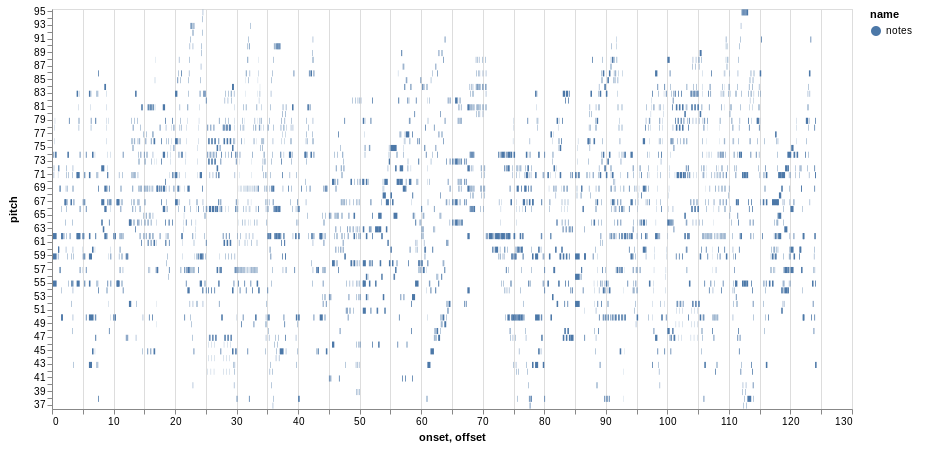

In [26]:
plotpolygrams(notes, map(first, wsearch))